### Breaking away from Karapthy to try to implement the MLP paper myself. This is 2 decade old tech so hopefully it's not so difficult!

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [3]:
# FIRST, i'll try to re-create makemore-1's 1 layer NN in pytorch. I have no idea what I'm doing (reading docs!)
class Bigram(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.randn((27, 27)))

    def forward(self, x_enc, ys=None):
        # xs --> input characters encoded with one_hot encoding
        # ys --> output characters for every x (not encoded)
        logits = x_enc @ self.W
        prob = F.softmax(logits, dim=1)
        # loss = mean negative log probability of the correct letter (ys) following the input
        if self.training:
            loss = -prob[torch.arange(x_enc.size(0)), ys].log().mean() 
            return logits, loss
        return logits, None

In [4]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [5]:
# data
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        x, y = stoi[ch1], stoi[ch2]
        xs.append(x)
        ys.append(y)
xs, ys = torch.tensor(xs, device=device), torch.tensor(ys, device=device)
x_enc = F.one_hot(xs, num_classes=27).float()

In [6]:
# training
bigram = Bigram()
bigram.to(device)

optimizer = torch.optim.SGD(bigram.parameters(), lr=50, weight_decay=0.0, momentum=0.0)

loss = None
for _ in range(100):
    _, loss = bigram.forward(x_enc, ys)
    bigram.zero_grad()
    loss.backward()
    optimizer.step()
print(loss.data)
bigram.eval()



tensor(2.4736, device='mps:0')


Bigram()

In [7]:
# test
g = torch.Generator(device=device).manual_seed(2147483647)
for _ in range(20):
    out = []
    ix = 0
    while True:
        input_char = F.one_hot(torch.tensor([ix], device=device), num_classes=27).float()
        logits, _ = bigram.forward(input_char)
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))
    

daima.
sason.
odqush.
jarascevonn.
ehirulystz.
ceyn.
th.
kyn.
coromarikorimolirrasi.
k.
ayanedin.
eillanyupeeke.
ka.
horly.
kyiavy.
be.
rilelleal.
qudigmodan.
jariyliler.
onalydan.


In [8]:
class MLP(nn.Module):
    # m --> numnber of features
    # n --> context size
    # h --> number of hidden units
    def __init__(self, m, n, h):
        super().__init__()
        self.C = nn.Embedding(27, m)
        self.mlp = nn.Sequential(
            nn.Linear(m * n, h),
            nn.Tanh(),
            nn.Linear(h, 27)
        )
        self.m = m
        self.n = n
        self.h = h

    def forward(self, xs, ys=None):
        features = self.C(xs).view((-1, self.m * self.n))
        logits = self.mlp(features)
        prob = F.softmax(logits, dim=1)

        if self.training:
            loss = -prob[torch.arange(xs.size(0)), ys].log().mean()
            return logits, loss
        return logits, None

In [9]:
t = torch.arange(3 * 2 * 4).reshape((3, 2, 4))
print(t)
t = t.reshape((3, 8))
print(t)

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23]]])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20, 21, 22, 23]])


In [10]:
# create dataset
xs = []
ys = []
for word in words:
    chrs = ['.', '.', '.'] + list(word) + ['.']
    for i in range(3, len(chrs)):
        x = [stoi[c] for c in chrs[i-3:i]]
        y = stoi[chrs[i]]
        xs.append(x)
        ys.append(y)
xs = torch.tensor(xs).to(device=device)
ys = torch.tensor(ys).to(device=device)
print(f'{xs=}')
print(f'{ys=}')
print(xs.shape)

xs=tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]], device='mps:0')
ys=tensor([ 5, 13, 13,  ..., 26, 24,  0], device='mps:0')
torch.Size([228146, 3])


In [11]:
# NOW, back to Bengio et. al
ix = xs.to('cpu')
iy = ys.to('cpu')
C = nn.Embedding(27, 10) # we are storing 10 "features" on each character
hidden = nn.Linear(30, 60)
tanh = nn.Tanh()
output = nn.Linear(60, 27)
features = C(ix).view(-1, 30)
print(features.shape)
hidden_applied = hidden(features)
logits = output(tanh(hidden_applied))
prob = F.softmax(logits, dim=1)
loss = -prob[torch.arange(ix.size(0)), iy].log().mean()
loss

torch.Size([228146, 30])


tensor(3.3454, grad_fn=<NegBackward0>)

In [232]:
xs[torch.randint(0, xs.size(0), (32,))]

tensor([[ 1,  3, 11],
        [ 9, 25,  1],
        [ 0, 14,  9],
        [ 0,  0,  0],
        [ 0, 10,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [12, 25, 14],
        [ 4,  1, 19],
        [ 1, 14,  7],
        [12, 25, 14],
        [ 0,  0,  2],
        [ 5,  4, 18],
        [ 9, 15, 14],
        [ 0, 11,  5],
        [18,  9, 11],
        [ 0,  0,  5],
        [ 0,  0,  0],
        [ 0, 16,  1],
        [18,  9,  5],
        [ 0,  0,  2],
        [ 1,  8,  5],
        [12, 15, 18],
        [ 1,  1, 22],
        [ 0,  0,  0],
        [20, 20, 15],
        [ 0,  0,  0],
        [12, 25, 19],
        [ 7,  1, 14],
        [ 5,  5, 14],
        [14, 14,  5],
        [ 0,  0,  0]], device='mps:0')

In [20]:
batch_time = []
forward_time = []
zero_grad_time = []
backward_time = []
optimizer_time = []

mps_batch_time = []
mps_forward_time = []
mps_zero_grad_time = []
mps_backward_time = []
mps_optimizer_time = []

In [22]:
import time
from datetime import timedelta
# initialize model
mps = torch.device('mps')
cpu = torch.device('cpu')
device = mps
xs = xs.to(cpu)
ys = ys.to(cpu)
mlp = MLP(10, 3, 200).to(device=device)

# Warm-up
for _ in range(100):
    torch.matmul(torch.rand(500,500).to(device), torch.rand(500,500).to(device))
# train
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
mlp.train()

loss = None
start_time = time.time()

for epoch in range(50_000):
    # minibatch
    s = time.time()
    batch = torch.randint(0, xs.size(0), (32,))
    # mps_batch_time.append(time.time() - s);   s = time.time()
    ix = xs[batch].to(mps)
    iy = ys[batch].to(mps)
    _, loss = mlp.forward(xs[batch], ys[batch])
    # mps_forward_time.append(time.time() - s); s = time.time()

    mlp.zero_grad()
    # mps_zero_grad_time.append(time.time() - s); s = time.time()
    loss.backward()
    # mps_backward_time.append(time.time() - s); s = time.time()

    optimizer.step()
    # mps_optimizer_time.append(time.time() - s); s = time.time()
    if epoch % 10000 == 0:
        time_elapsed = timedelta(seconds=int(time.time() - start_time))
        print(f'epoch: {epoch}\t\t time: {time_elapsed}\t\t loss: {loss.item()}')
print(loss.data)


tensor(2.2765, device='mps:0')


In [270]:
mlp.eval()
for _ in range(20):
    out = ['.', '.', '.']
    while True:
        ix = 0
        ctx = torch.tensor([stoi[i] for i in out[-3:]]).reshape(1, 3).to(device=device)
        logits, _ = mlp.forward(ctx)
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, 1, replacement=True).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out)[3:])

ailax
ryn
yovy
ann
ber
maharid
mariki
lija
avirtevilxyn
lon
tio
iyah
kan
mivionen
zim
jakanna
cha
dalya
adamari
masiem


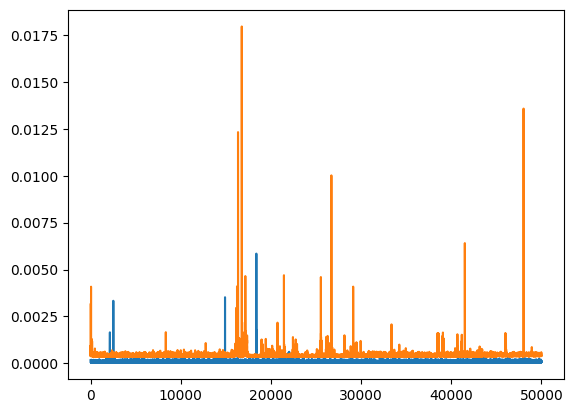

In [29]:
plt.plot(backward_time, label='cpu')
plt.plot(mps_backward_time, label='mps')